# 목적
* 블로그 내용을 긁어와서 연관분석 진행
1. keyword관련 블로그 크롤링 
    정확도 기준으로 긁어오되 날짜도 같이 가져와서 나중 어떤 날짜에 집중되어 있는지 확인  
    한 블로그당 단어빈도수 분석(필요할까)
2. 블로그 내 단어 토크나이즈하고 
3. 연관분석실시


# 선행설치

In [1]:
# 선행설치
# # 크롤링
# !pip install beautifulsoup4
# !pip install requests
# !pip install lxm
# # 연관분석
# !pip install apyori
# # 자연어처리
# !pip install konlpy (JDK 설치가 되어있어야함 )
# # 워드클라우드
# !pip install wordcloud

In [2]:
# import
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook  # 진행과정 시각화
from datetime import timedelta  # 시간날짜
from apyori import apriori  # 연관분석

import re
import json
import math
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup  # 크롤링

from PIL import Image
import numpy as np
import wordcloud
import random

import konlpy
from konlpy.tag import Komoran,Kkma,Okt,Twitter  # 자연어처리
# from eunjeon import Mecab #은전한닢 mecab을 설치하면 먹통이됨 2020-04-10 10:10:10 작동안됨
# import MeCab # meacb 별도설치 2020-04-10 10:10:10 작동안됨
import kss

# mecab = Mecab()
okt = Okt()
komoran = Komoran(userdic='./user_dictionary.txt')

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

C:\Users\User\Anaconda3\lib\site-packages\jpype\_core.py:217: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


# 네이버 검색 URl구조

date_from - YYYYMMDD : 시작날짜 date_option 8일때   
date_option - int : 0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정  
date_to - YYYYMMDD : 마지막날짜 date_option 8일때  
dup_remove - int : 유사문서제거옵션 1 : 제거, 0 : 유지  
nso - str : _상세검색으로 추정_   
post_blogurl - ?  
post_blogurl_without - ?   
query - str : 검색어     
sm=tab_pge -?    
st - str : 정렬순서 sim : 유사도 date : 날짜    

In [3]:
# #네이버에서 검색했을때 url구조
# https://search.naver.com/search.naver
#     ?date_from=&
#     date_option=0&
#     date_to=&
#     dup_remove=1&
#     nso=&
#     post_blogurl=
#     &post_blogurl_without=
#     &query=%EC%96%91%EC%96%91
#     &sm=tab_pge
#     &srchby=all
#     &st=sim
#     &where=post
#     &start=11

In [4]:
def del_outword(string):
    '''
    이모티콘, \u200b과 같은 문자가 아닌 것 제거
    #이모티콘 제거 [출처](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
    '''
    #이모지제거
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~"^_\n\r#\ufeff\u200d\u200b\u7643\ufffd\u682e\u62c4]+')
    
    string = emoji_pattern.sub(r'',string)
    string = han.sub(r'',string)
    
    return string

In [5]:
def time_change(x):
    '''
    검색결과에 있는 문자를 날짜로 변경
    '''
    min_pattern = re.compile('[0-9]+'+"분 전")
    hour_pattern = re.compile('[0-9]+'+"시간 전")
    day_pattern = re.compile('[0-9]+'+"일 전")

    today = datetime.datetime.today().date()
    # 일자
    try:
        d = re.findall(day_pattern, x)[0][0]
        x = today - timedelta(days=int(d))
    except:
        pass
    # 시간
    try:
        d = re.findall(hour_pattern, x)[0]
        x = today
    except:
        pass
    # 분
    try:
        h = re.findall(min_pattern, x)[0]
        x = today
    except:
        pass

    if x == '어제':
        x = today - timedelta(days=1)

    elif type(x) == str:
        x = datetime.datetime.strptime(x.replace('.', '-')[:-1], '%Y-%m-%d')
    #모든일자를 1일로 통일
    x = datetime.datetime.strptime(x.strftime('%Y-%m')+"-01","%Y-%m-%d")
    return x

In [6]:
def naver_blog_crawling(keyword, start_num=1, end_num=101, date_option=0, date_from='', date_to='', save=True):
    '''
    네이버 블로그 크롤링 함수
    네이버 블로그 검색결과를 크롤링하며, 1페이지당 10개씩을 검색한다

    keyword : string
     검색하고 싶은 키워드를 넣는다
     "keyword +필수어" 형태로 필수단어 추가 가능
    start_num : int (default = 1) 
     시작할 위치 1로 끝나는 단위 추천
    end_num : int (default = 101)
     끝나는 위치 1로 끝나는 단위 추천
    date_option : int (default = 0)
     주어지는 숫자에 의해 검색방법이 변경됨
     0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정
    date_from : YYYYMMDD (default = "")
     date_option이 8일때 사용 검색 시작일자를 지정
    date_to : YYYMMDD (default = "")
     date_option이 8일때 사용 검색 마지막일자를 지정
    save : bool (default = True)
     csv로 저장 여부 결정
    '''
    # url 찾는 패턴
    pattern = re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')

    # 저장위치
    postdates = []
    strings = []
    urls = []
    titles = []
    output_error = []
    connection_error = []
    count = 1
    base_url_ls = []

    # keyword와 시작넘버만 바꾸면서 진행하게끔
    base_url = 'https://search.naver.com/search.naver?date_from={date_from}&date_option={date_option}&date_to={date_to}&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start}'

    # for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
    for i in tqdm_notebook(range(start_num, end_num+1, 10), desc="page work"):
        search_list = base_url.format(keyword=keyword, start=i,
                                      date_option=date_option, date_from=date_from, date_to=date_to)
        response = requests.get(search_list)
        base_url_ls.append(search_list)
        if response.status_code is 200:
            # 1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
            soup = BeautifulSoup(response.content, 'lxml')
            sections = soup.findAll('li', attrs={'class': 'sh_blog_top'})

            for section in sections:
                try:
                    # href부분만 가져오기 어려워서 정규표현식으로 검색
                    url = re.findall(pattern, str(section))[0].replace(
                        '?Redirect=Log&amp;logNo=', '/').replace('href="', '')
                    title = section.select_one('a.txt84').text
                    date = section.select_one('dd.txt_inline').text.strip()

                    # 블로그 url안에 들어가기(아직 크롤링불가)
                    get_blog_post_content_code = requests.get(url)
                    get_blog_post_content_text = get_blog_post_content_code.text
                    get_blog_post_content_soup = BeautifulSoup(
                        get_blog_post_content_text, 'lxml')

                    # 크롤링가능한 url에 접속
                    real_blog_post_url = "http://blog.naver.com" + \
                        get_blog_post_content_soup.select('#mainFrame')[
                            0].get('src')
                    get_real_blog_post_content_code = requests.get(
                        real_blog_post_url)
                    get_real_blog_post_content_text = get_real_blog_post_content_code.text
                    get_real_blog_post_content_soup = BeautifulSoup(
                        get_real_blog_post_content_text, 'lxml')

                    # url (에러나면 위에서부터 에러남)
                    urls.append(real_blog_post_url)
                    # 블로그명
                    titles.append(title)
                    # 날짜
                    postdates.append(date)

                    # 본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함)
                    try:
                        blog_post_content = get_real_blog_post_content_soup.select(
                            'div#postViewArea')
                        if len(blog_post_content) == 0:
                            blog_post_content = get_real_blog_post_content_soup.select(
                                'div.se-main-container')
                            if len(blog_post_content) == 0:
                                blog_post_content = get_real_blog_post_content_soup.select(
                                    'div.se_component_wrap.sect_dsc.__se_component_area')

                        string = ""
                        for sentence in blog_post_content[0].stripped_strings:
                            string += " "+sentence.replace('\xa0', " ")
                            # 비언어 텍스트제거
                            string = del_outword(string)
                        #공백에러대처
                        blank_check = string.replace(" ","")
                        if len(blank_check) == 0:
                            strings.append(["X"])
                        else : 
                            strings.append([string])
                        count += 1
                    except:
                        strings.append(["X"])
                        count += 1

                except Exception as ex:
                    # print('가져오기에러 {num}번째'.format(num = count),ex)
                    output_error.append(count)
                    count += 1
                    pass
        else:
            # print('연결오류 {num}번째'.format(num = count),response.status_code)
            connection_error.append(count)
            count += 1

    out_length = len(output_error+connection_error)
    real_length = end_num-start_num+10-out_length
    crawling_df = pd.DataFrame(
        {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})
    crawling_df['post_dates'] = crawling_df['post_dates'].apply(
        lambda x: time_change(x))

    # 중복제거
    crawling_df.drop_duplicates("url", inplace=True)
    crawling_df.reset_index(drop=True, inplace=True)
    real_length = crawling_df.shape[0]

    # 결과출력
    print("검색한 길이:", end_num-start_num+10)
    print("제외된 길이:", out_length)
    print("검색된 길이:", real_length)
    if save == True:
        today = datetime.datetime.today().date()
        str(today)
        crawling_df.to_csv(str(today)+"_"+keyword+"_" +
                           str(real_length)+'.csv', encoding='utf-8', index=False)
#     return strings, urls, postdates
    return crawling_df, output_error, real_length

In [7]:
# keyword검색시 "검색어 +필수어" 형태로 필수단어 삽입가능
today = datetime.datetime.today().date()
keyword = "인구 +양양"
start_num = 1
end_num = 701
date_option = 0
date_from = "20150101"
date_to = "20190101"

In [8]:
crawling_df, output_error, real_length = naver_blog_crawling(keyword, start_num, end_num, date_option, date_from, date_to, save=False)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



검색한 길이: 710
제외된 길이: 124
검색된 길이: 562


### 추출된 데이터 일자별 집중도 확인

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


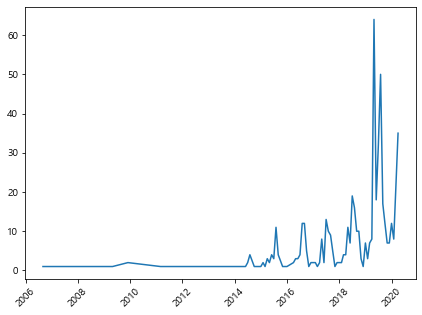

In [9]:
plt.figure(figsize=(7,5))
plt.plot(crawling_df['post_dates'].value_counts().sort_index())
plt.xticks(rotation = 45)
# plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_날짜빈도'+'.png')
plt.show()

### 토크나이즈

### 형용사 - 연구중 2020-04-06 13:03:43 
* 각 형태소 분석기 비교
1. komoran/mecab 어간/어미를 분해해서 다소 카운팅하기 어려움
2. okt adjective로 되어있어 다소 편리하면서 더 많은 형용사를 끌어옴

In [10]:
all_va = []
VA_ls = []

sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
               "메뉴", "주문", "강원도", '정도', '도착', '생각', '양양군', '사진', '위치', '라고', '양양', "아침", "저녁", '다음', '우리', '시작', '여기', '이곳', '사람',
              "이다", "많다","좋다","같다","없다","그렇다","이렇다","아니다","안녕하다","가능하다"]))

for i in tqdm_notebook(range(0,len(crawling_df))):
    VA_ls = []
    #어근만 추출
    pos_text = okt.pos(crawling_df['full_text'][i][0], norm=True, stem=True)
    for j in range(0,len(pos_text)):
        if pos_text[j][1] == 'Adjective':
            text = pos_text[j][0]
            VA_ls.append(text)
    clean_va = list(filter(lambda word : (len(word)>1)&(word not in sw),VA_ls))
    clean_va = list(set(clean_va))
    all_va.append(clean_va)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [11]:
all_va_flatten = [y for x in all_va for y in x]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

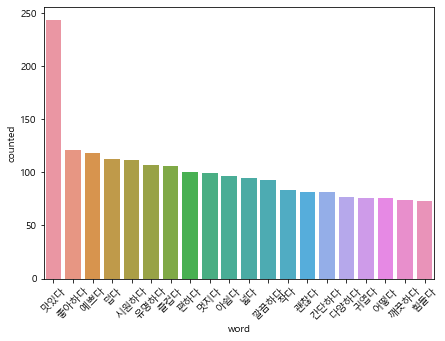

In [12]:
count_df = pd.Series(all_va_flatten).value_counts().reset_index()

count_df.columns = ['word','counted']

plt.figure(figsize=(7,5))
sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
plt.xticks(rotation = 45)

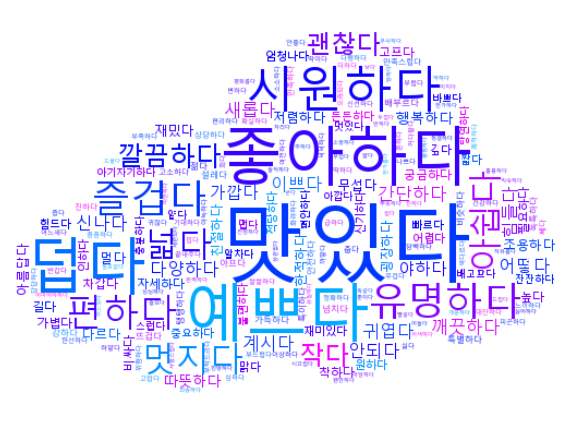

In [13]:
#워드클라우드

#마스킹 준비
from PIL import Image
import numpy as np
import wordcloud
import random

img_path = "vector-cloud-png.png"
img = Image.open(img_path).convert('RGBA')
mask = Image.new("RGB", img.size, (255,255,255))
mask.paste(img, img)
mask = np.array(mask)

text= ' '.join(all_va_flatten)

wordc = wordcloud.WordCloud(background_color = 'White', max_words= 200,
                           font_path = 'C:/Windows/Fonts/malgun.ttf',
                           relative_scaling = 0.5,
                           stopwords= sw,
                           collocations = False,
                        mask = mask)
wordc.generate(text)

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(%d,100%%,50%%)' % random.randint(200,300) #색상 채도 밝기
wordc.recolor(color_func = grey_color, random_state =3)

#그리기
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(wordc, interpolation = 'bilinear')
#저장
plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_워드클라우드'+'.png')
plt.show()

### 문장단위 컷
* 특정 키워드가 들어간 문장을 추출하고 그 문장내 있는 단어 추출

In [30]:
sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
               "메뉴", "주문", "강원도", '정도', '도착', '생각', '양양군', '사진', '위치', '라고', '양양', "아침", "저녁", '다음', '우리', '시작', '여기', '이곳', '사람',
              "이다", "많다","좋다","같다","없다","그렇다","이렇다","아니다","안녕하다","가능하다"]))

final_words = []
#크롤링전체
for blog_num in tqdm_notebook(range(0, len(crawling_df['full_text']))):
    sentences = kss.split_sentences(crawling_df['full_text'][blog_num][0])
    #블로그하나 내 문장분석
    one_blog_words =[]
    for sen_num in range(0, len(sentences)):
        pos_text = okt.pos(sentences[sen_num], norm=True, stem=True)
        one_text = []
        #문장 내 단어 추출
        for word_num in range(0,len(pos_text)):
            if (pos_text[word_num][1] == "Adjective")|(pos_text[word_num][1] == "Noun"):
                text = pos_text[word_num][0]
                clean_words = list(filter(lambda word : (len(word)>1)&(word not in sw),text))
                one_text.append(clean_words)
        one_blog_words.append(clean_words)
    #특정키워드가 있는 문장의 위치
    word_in_setence_ls = []
    for i in range(0, len(one_blog_words)):
        if "맛있다" in one_blog_words[i]:
            word_in_setence_ls.append(i)
    #최종적으로 키워드문장내 형용사/명사 추출
    for dx in word_in_setence_ls:
        if len(one_blog_words[dx])>1:
            final_words.append(one_blog_words[dx])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


### 특정키워드 연관분석

In [14]:
words_df = pd.DataFrame({'words':final_words})
rules = apriori(all_words, min_support=0.2, min_condience =0.3)
results  = list(rules)

NameError: name 'all_words' is not defined

In [ ]:
results_df = pd.DataFrame(columns =["lhs",'rhs','support','confidence','lift'])
index =0
for row in results:   
    support = row[1]
    ordered_stat = row[2]
    for ordered_item in ordered_stat:
        lhs = " ".join(x for x in ordered_item[0])
        rhs = " ".join(x for x in ordered_item[1])
        confidence = ordered_item[2]
        lift = ordered_item[3]
        results_df.loc[index] = [lhs,rhs,support,confidence,lift]
        index = index +1

results_df = results_df.sort_values(by="lift",ascending=False)

In [ ]:
results_df

### 함수화전(형용사+명사)
1.Okt만 사용
2.mecab(nouns), okt(adjective)

In [17]:
target = crawling_df['full_text']
tagger = okt
unique = False
save = True

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

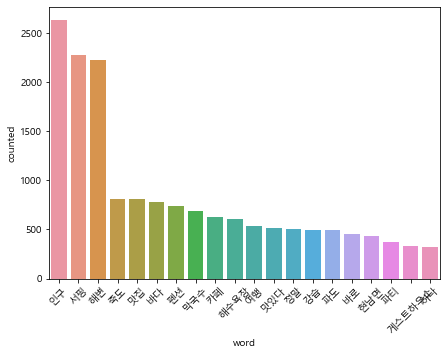

In [15]:
sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
               "메뉴", "주문", "강원도", '정도', '도착', '생각', '양양군', '사진', '위치', '라고', '양양', "아침", "저녁", '다음', '우리', '시작', '여기', '이곳', '사람',
               "지도","보기","상세","전화",
              "이다", "많다","좋다","같다","없다","그렇다","이렇다","아니다","안녕하다","가능하다"]))
all_words =[]

for blog_num in tqdm_notebook(range(0,len(crawling_df))):
    #블로그 품사태깅
    pos_text = okt.pos(target[blog_num][0], norm=True, stem=True)
    
    pos_text_df = pd.DataFrame(pos_text)
    words = pos_text_df[pos_text_df[1].apply(lambda x : (x in "Noun") | (x in "Adjective"))][0].values
    clean_words = list(filter(lambda word : (len(word)>1)&(word not in sw),words))
    
    if unique == True:
        clean_words = list(set(clean_words))
    all_words.append(clean_words)

#2중리스트 flatten
all_word_flatten = [y for x in all_words for y in x]

count_df = pd.Series(all_word_flatten).value_counts().reset_index()

count_df.columns = ['word','counted']
#그래프
plt.figure(figsize=(7,5))
sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
plt.xticks(rotation = 45)

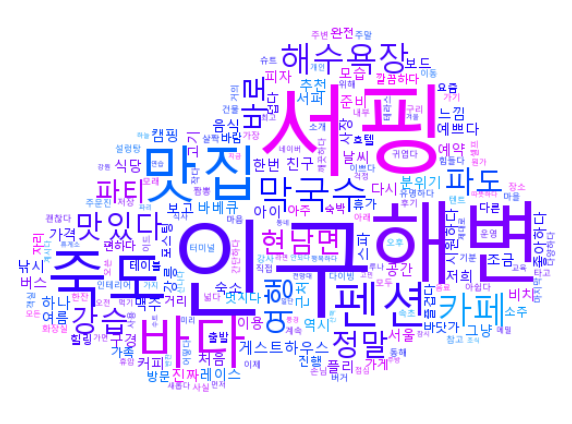

In [18]:
# 워드클라우드
# 마스킹
img_path = "vector-cloud-png.png"
img = Image.open(img_path).convert('RGBA')
mask = Image.new("RGB", img.size, (255, 255, 255))
mask.paste(img, img)
mask = np.array(mask)

text = ' '.join(all_word_flatten)

wordc = wordcloud.WordCloud(background_color='White', max_words=200,
                            font_path='C:/Windows/Fonts/malgun.ttf',
                            relative_scaling=0.5,
                            stopwords=sw,
                            collocations=False,
                            mask=mask)
wordc.generate(text)

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(%d,100%%,50%%)' % random.randint(200, 300)  # 색상 채도 밝기
wordc.recolor(color_func=grey_color, random_state=3)

# 그리기
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordc, interpolation='bilinear')
# 저장
if save == True:
    plt.savefig("./output/워드클라우드/"+str(today)+"_"+keyword +
                "_"+str(real_length)+'_워드클라우드'+'.png')
plt.show()

In [33]:
words_df = pd.DataFrame({'words':all_words})
rules = apriori(all_words, min_support=0.1, min_condience =0.1)
results  = list(rules)

results_df = pd.DataFrame(columns =["lhs",'rhs','support','confidence','lift'])
index =0
for row in results:   
    support = row[1]
    ordered_stat = row[2]
    for ordered_item in ordered_stat:
        lhs = " ".join(x for x in ordered_item[0])
        rhs = " ".join(x for x in ordered_item[1])
        confidence = ordered_item[2]
        lift = ordered_item[3]
        results_df.loc[index] = [lhs,rhs,support,confidence,lift]
        index = index +1

results_df = results_df.sort_values(by="lift",ascending=False)

In [24]:
results_df.head(30)

,lhs,rhs,support,confidence,lift
655,지도 상세,보기 전화 강현면,0.122040,0.858974,6.834448
658,보기 전화 강현면,지도 상세,0.122040,0.971014,6.834448
635,지도 상세,보기 전화,0.140255,0.987179,6.774519
632,보기 전화,지도 상세,0.140255,0.962500,6.774519
661,지도 강현면 상세,보기 전화,0.122040,0.985294,6.761581
652,보기 전화,지도 강현면 상세,0.122040,0.837500,6.761581
656,지도 전화,보기 강현면 상세,0.122040,0.827160,6.678105
657,보기 강현면 상세,지도 전화,0.122040,0.985294,6.678105
665,보기 지도 전화,강현면 상세,0.122040,0.848101,6.651537
651,보기 상세,지도 전화 강현면,0.122040,0.848101,6.651537


### 함수화(명사)

In [33]:
#형태소분석기 종류비교
# mecab = Mecab()
komoran = Komoran(userdic='user_dictionary.txt')
kkma = Kkma()
okt = Okt()
twitter = Twitter()

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [34]:
def tokenaize(tagger, target, unique = False, save = True):
    sw = ['오늘','시간','최근','지난','관련','이번','이날','현재','10','올해','지난해','있다','이상','기준','때문',
     "메뉴","주문","강원도",'정도','도착','생각','양양군','사진','위치','라고']
    all_nouns =[]

    for i in tqdm_notebook(range(0,len(crawling_df))):
        nouns = tagger.nouns(target[i][0])
        clean_nouns = list(filter(lambda word : (len(word)>1)&(word not in sw),nouns))
        if unique == True:
            clean_nouns = list(set(clean_nouns))
        all_nouns.append(clean_nouns)
        
    #2중리스트 flatten
    all_noun_flatten = [y for x in all_nouns for y in x]

    count_df = pd.Series(all_noun_flatten).value_counts().reset_index()

    count_df.columns = ['word','counted']

    plt.figure(figsize=(7,5))
    sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
    plt.xticks(rotation = 45)
    if save == True:
        count_df.to_csv("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_단어빈도'+'.csv',encoding ='cp949')
        plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_단어빈도'+'.png')
    plt.show()
    
    return all_nouns

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


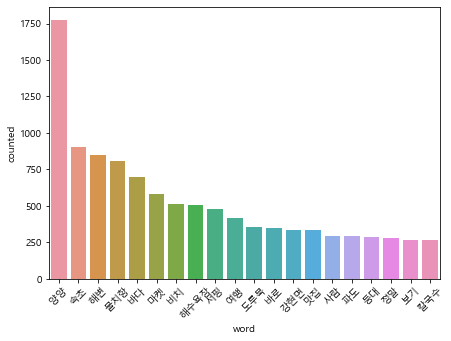

In [35]:
all_nouns = tokenaize(okt,crawling_df['full_text'])

In [37]:
all_noun_flatten = [y for x in all_nouns for y in x]

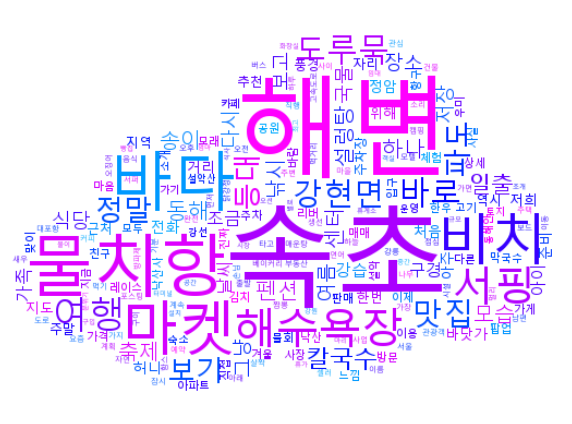

In [38]:
# 워드클라우드
# 마스킹
img_path = "vector-cloud-png.png"
img = Image.open(img_path).convert('RGBA')
mask = Image.new("RGB", img.size, (255, 255, 255))
mask.paste(img, img)
mask = np.array(mask)

text = ' '.join(all_noun_flatten)

wordc = wordcloud.WordCloud(background_color='White', max_words=200,
                            font_path='C:/Windows/Fonts/malgun.ttf',
                            relative_scaling=0.5,
                            stopwords=sw,
                            collocations=False,
                            mask=mask)
wordc.generate(text)

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(%d,100%%,50%%)' % random.randint(200, 300)  # 색상 채도 밝기
wordc.recolor(color_func=grey_color, random_state=3)

# 그리기
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordc, interpolation='bilinear')
# 저장
if save == True:
    plt.savefig("./output/워드클라우드/"+str(today)+"_"+keyword +
                "_"+str(real_length)+'_워드클라우드'+'.png')
plt.show()

### 연관분석

In [38]:
rules = apriori(all_words, min_support=0.1, min_condience =0.1)
results  = list(rules)

results_df = pd.DataFrame(columns =["lhs",'rhs','support','confidence','lift'])
index =0
for row in results:   
    support = row[1]
    ordered_stat = row[2]
    for ordered_item in ordered_stat:
        lhs = " ".join(x for x in ordered_item[0])
        rhs = " ".join(x for x in ordered_item[1])
        confidence = ordered_item[2]
        lift = ordered_item[3]
        results_df.loc[index] = [lhs,rhs,support,confidence,lift]
        index = index +1

results_df = results_df.sort_values(by="lift",ascending=False)

In [39]:
results_df.head(50)

,lhs,rhs,support,confidence,lift
175,마켓,비치,0.136612,0.961538,5.278846
176,비치,마켓,0.136612,0.750000,5.278846
170,송이,등대,0.100182,0.785714,4.493304
169,등대,송이,0.100182,0.572917,4.493304
382,등대,물치항 바다,0.118397,0.677083,2.926919
387,물치항 바다,등대,0.118397,0.511811,2.926919
136,국물,맛있다,0.109290,0.810811,2.459310
137,맛있다,국물,0.109290,0.331492,2.459310
178,맛있다,맛집,0.138434,0.419890,2.305193
179,맛집,맛있다,0.138434,0.760000,2.305193


# 검수용코드

In [128]:
# real_blog_post_url = 'http://blog.naver.com/PostView.nhn?blogId=kjakfldh&logNo=221008785961&redirect=Dlog&widgetTypeCall=true&directAccess=false'
# real_blog_post_url = 'http://blog.naver.com/PostView.nhn?blogId=ghskal&logNo=220806425747&redirect=Dlog&widgetTypeCall=true&directAccess=false'
real_blog_post_url = 'http://blog.naver.com/PostView.nhn?blogId=skygirleunji&logNo=221620476332&redirect=Dlog&widgetTypeCall=true&directAccess=false'

In [129]:
get_real_blog_post_content_code = requests.get(real_blog_post_url)
get_real_blog_post_content_text = get_real_blog_post_content_code.text
get_real_blog_post_content_soup = BeautifulSoup(get_real_blog_post_content_text, 'lxml')

In [130]:
blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
if len(blog_post_content) == 0:
    blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
    if len(blog_post_content) == 0:
        blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')

In [137]:
string = crawling_df['full_text'][i][0]

In [132]:
strings = []
string = ""
for sentence in blog_post_content[0].stripped_strings:
    string += " "+sentence.replace('\xa0', " ")
    # 비언어 텍스트제거
    string = del_outword(string)
blank_check = string.replace(" ","")
if len(blank_check) == 0:
    strings.append(["X"])
else : 
    strings.append([string])


In [133]:
# 1개코드
# 저장위치
postdates = []
strings = []
urls = []
titles = []
output_error = []
connection_error = []
count = 1

pattern = re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')
# keyword와 시작넘버만 바꾸면서 진행하게끔
base_url = 'https://search.naver.com/search.naver?date_from=&date_option=0&date_to=&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start_num}'

# for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
search_list = base_url.format(keyword="전진리 +양양", start_num=13)
response = requests.get(search_list)

if response.status_code is 200:
    # 1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
    soup = BeautifulSoup(response.content, 'lxml')
    sections = soup.findAll('li', attrs={'class': 'sh_blog_top'})
    section = sections[0]

    # href부분만 가져오기 어려워서 정규표현식으로 검색
    url = re.findall(pattern, str(section))[0].replace(
        '?Redirect=Log&amp;logNo=', '/').replace('href="', '')
    title = section.select_one('a.txt84').text
    date = section.select_one('dd.txt_inline').text.strip()

    # 블로그 url안에 들어가기(아직 크롤링불가)
    get_blog_post_content_code = requests.get(url)
    get_blog_post_content_text = get_blog_post_content_code.text
    get_blog_post_content_soup = BeautifulSoup(get_blog_post_content_text, 'lxml')

    # 크롤링가능한 url에 접속
    try:
        real_blog_post_url = "http://blog.naver.com" + \
        get_blog_post_content_soup.select('#mainFrame')[0].get('src')
        get_real_blog_post_content_code = requests.get(real_blog_post_url)
        get_real_blog_post_content_text = get_real_blog_post_content_code.text
        get_real_blog_post_content_soup = BeautifulSoup(
        get_real_blog_post_content_text, 'lxml')
    except:
        real_blog_post_url = url
        get_real_blog_post_content_code = requests.get(real_blog_post_url)
        get_real_blog_post_content_text = get_real_blog_post_content_code.text
        get_real_blog_post_content_soup = BeautifulSoup(
        get_real_blog_post_content_text, 'lxml')
        pass

    # url (에러나면 위에서부터 에러남)
    try:
        urls.append(real_blog_post_url)
    except:
        urls.append(url)
    # 블로그명
    titles.append(title)
    # 날짜
    postdates.append(date)

    # 본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함)
    try:
        blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
        if len(blog_post_content) == 0:
            blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
            if len(blog_post_content) == 0:
                blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')
            
        string = ""
        for sentence in blog_post_content[0].stripped_strings:
            string += " "+sentence.replace('\xa0', " ")
            # 비언어 텍스트제거
            string = del_outword(string)
        #공백에러대처
        blank_check = string.replace(" ","")
        if len(blank_check) == 0:
            strings.append(["X"])
        else : 
            strings.append([string])
        count += 1
            
    except:
        strings.append([np.NaN])
        count += 1


crawling_df = pd.DataFrame(
    {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})

In [138]:
blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
if len(blog_post_content) == 0:
    blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
    if len(blog_post_content) == 0:
        blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')

string = ""
for sentence in blog_post_content[0].stripped_strings:
    string += " "+sentence.replace('\xa0'," ")

strings.append([string])
count += 1

IndexError: list index out of range

# 발생한 오류

# 형용사 -개발단위
* 각 형태소 분석기 비교
1. komoran/mecab 어간/어미를 분해해서 다소 카운팅하기 어려움
2. okt adjective로 되어있어 다소 편리하면서 더 많은 형용사를 끌어옴

In [178]:
pos_df = pd.DataFrame()
va_df = pd.DataFrame()

In [179]:
okt = Okt()

In [187]:
#단하나 
VA_ls = []
pattern = re.compile("VA[+A-z]*")

pos_text = okt.pos(crawling_df['full_text'][1][0])
for i in range(0,len(pos_text)):
    try:
        re.search(pattern,pos_text[i][1]).group()
        text = pos_text[i][0]
        VA_ls.append(text)
    except: 
        pass

In [190]:
#okt 별도 
VA_ls = []
for i in range(0,len(pos_text)):
    if pos_text[i][1] == 'Adjective':
        text = pos_text[i][0]
        VA_ls.append(text)

In [192]:
va_df = pd.concat([va_df,pd.Series(list(set(VA_ls)))],axis = 1)

In [194]:
va_df.to_csv('va_df.csv',encoding='cp949')

In [154]:
pos_df = pd.concat([pos_df,pd.DataFrame(pos_text)],axis =1)

In [155]:
pos_df

,0,1,0,1,0,1
0,홍,NNP,홍천,NNG,홍천,Noun
1,천,NNP,에서,JKB,에서,Josa
2,에서,JKB,양양,NNP,양양,Noun
3,양양,NNP,으로,JKB,으로,Josa
4,으로,JKB,출발,NNG,출발,Noun
...,...,...,...,...,...,...
996,치,XSN,NaN,NaN,NaN,NaN
997,리,NNB,NaN,NaN,NaN,NaN
998,7,SN,NaN,NaN,NaN,NaN
999,-,SW,NaN,NaN,NaN,NaN


In [156]:
pos_df.to_csv('pos_df.csv',encoding = 'cp949')

In [129]:
#단하나 mecab
VA_ls = []
pattern = re.compile("VA[+A-z]*")

pos_text = mecab.pos(crawling_df['full_text'][1][0])
for i in range(0,len(pos_text)):
    try:
        re.search(pattern,pos_text[i][1]).group()
        text = pos_text[i][0]
        VA_ls.append(text)
    except: 
        pass

### 2020-04-06 09:23:51 크롤링중복오류 -> 1000개는 힘들다
* 약 600번대 이상부터 중복이 발생하는 것으로 보임
* 기사문 +양양 약 178개 중복
* 광진 +양양 약 215개 중복  

-> 원인은 네이버 검색의 특성상 관련검색어가 부족하면 중복되어서 나오는듯함
211번대와 161번대의 검색된 값이 유사함 

https://search.naver.com/search.naver?date_from=20190304&date_option=8&date_to=20200406&dup_remove=1&nso=p%3Afrom20190304to20200406&post_blogurl=&post_blogurl_without=&query=%EA%B4%91%EC%A7%84%20%2B%EC%96%91%EC%96%91&sm=tab_pge&srchby=all&st=sim&where=post&start=161

https://search.naver.com/search.naver?date_from=20190304&date_option=8&date_to=20200406&dup_remove=1&nso=p%3Afrom20190304to20200406&post_blogurl=&post_blogurl_without=&query=%EA%B4%91%EC%A7%84%20%2B%EC%96%91%EC%96%91&sm=tab_pge&srchby=all&st=sim&where=post&start=211

### 2020-04-07 09:31:08 komoran, java.lang.NullPointerException 오류
* konlpy의 komoran 사용시 에러발생 현재 코모란방식으로 등록해둔 사용자정의 사전이 있어 확인필요 (Okt, mecab은 정상작동)
-> 원인은 공백만 들어있는 문장이 있어서 발생 공백을 모두 제거한 길이가 0이면 X로 대체하도록 변경